In [1]:
%matplotlib inline

import csv
import os
import requests
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as py 
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
from datetime import datetime
from requests import get
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from urllib.request import urlopen

sns.set(color_codes=True)

In [3]:
os.getcwd()

'C:\\Users\\gouki\\ML1\\QTW2'

# Abstract
 
The goal of this assignment has 3 key components. The first is to research and obtain the relevant data from a website by using web scraping techniques. The second is to clean, parse and organize the scaped data into a single dataframe. The finale step is to perform an exploratory and statistical analysis on the dataset to help answer a question. The dataset and website in question is The Credit Union Cherry Blossom Ten Mile Run and 5K Run-Walk race results for the female runners in the 10 miles races. The website cherryblossom.org contains race results from 1999 - 2019, however we will be focusing on the results from 1999 to 2012. Using this specific race and time frame, we are focusing on reviewing whether the age distribution changed among the female race contestants over the years. Using a series of EDA, linear regression, change point analysis, and Anova we found that there was some significant movement in age over the span of the years.


# Introduction

The Credit Union Cherry Blossom Ten Mile Run is an annual run held in Washington, D.C. that brings together credit unions from across the country with a shared vision of fund raising and helping children. The proceeds from donations, registration fees, and merchandise sales from the event support Children’s Hospitals that belong to the non-profit Children's Miracle Network.

Since the innuagural run in 1973, hundreds of thousands of runners from around the world have participated in the event. The registration of each runners name, age, hometown, and race times provide an enormous trove of information regarding potential trends in the age and performance of runners over the years. The organizations website http://www.cherryblossom.org/ provides records of this data going back to 1999. This analysis will use web scraping to collect data from the website, inspect and clean the data, convert the data into a clean data frame, conduct exploratory data analysis and determine if ...        

    

# Data
Data for this analysis was taken from the Credit Union Cherry Blossom Ten Mile Run sites searcheable results web page using the URL http://www.cballtimeresults.org/performances?division=Overall+Women&page=1&section=10M&sex=W&utf8=%E2%9C%93&year=1999 as our initial reference for our web scraping function.

![title](https://github.com/dhyanshah/MS7333_QTW/blob/master/Case4/Python/CherryBlossom10M.png?raw=1)

Each page yielded only 20 runners and the number of female runners per year varied from 2,166 to 11,042, however from page to page the URL remained consistant making it relatively simple to iteratively cycle through the **page=** and **year=** variables of the URL. After an examination of the page source it was determined that the values: *"Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", and "Hometown"* could be obtained for each runner. A CSV file was the created with the appropriate headers to store the scraped data.

In [109]:
#create outputfile
outputFile = "CherryBlossomWomens10M.csv"

#create headers
file = open("CherryBlossomWomens10M.csv", "w",encoding='utf8' )
writer = csv.DictWriter(
    file, fieldnames=["Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", "Hometown", 'State','Blank1','Blank2',])
writer.writeheader()
file.close()

In [110]:
#split the marathon url into two parts to format page number and year
websiteURLpart1 = "http://www.cballtimeresults.org/performances?division=Overall+Women&page="
websiteURLpart2 = "&section=10M&sex=W&utf8=%E2%9C%93&year="

Through an examination of the page source it was determined that 'tr class='print-link-color' indicated entries for a new runner and two functions where created. The first function would update the URL **page=** and **year=** and the second function would parse the URL calling the first function to update the URL when no more 'tr class='print-link-color' entries where found on the page and update the year when the end page was reached.   

In [0]:
#create url function to format the url that is then passed to requests to get the html page
def createURL(url1, url2, pageNum, year):
    return(url1 + str(pageNum) + url2 + str(year))

#create parsing function that uses createURL to iterate through pages
def getRunners(url1, url2):
    year = 1999
    #iterate through all years from 1999 to 2018
    while(year < 2019):
        pageNum = 1
        morePages = True
        #iterate through all pages in each year
        while(morePages):
            websiteURL = createURL(url1, url2, pageNum, year)
            with open(outputFile, "a", encoding='utf8') as f:
                #requests return the html of the page in a raw object
                page = requests.get(websiteURL)
                #Beautiful Soup parses the requests object into a better formatted html object
                soup = BeautifulSoup(page.content, "html.parser")
                newLine = ""
                contents = soup.find_all("tr", class_="print-link-color")
                #check if the table is empty, if so, go to the next year
                if not contents:
                    morePages = False
                    year += 1
                #if the table has content
                else:
                    #iterate through all of the table rows that have class=print-link-color
                    for tr in soup.find_all("tr", class_="print-link-color"):
                        #add the previously parsed line to the file
                        if(newLine != ""):
                            f.write(newLine.rstrip(","))
                        newLine = ""
                        f.write("\n")
                        firsta = True
                        for a in tr.select("td a"):
                            if(firsta):    
                                f.write(a.getText().split()[0])
                                firsta = False
                            else:
                                f.write(a.getText())
                            f.write(",")
                    #once all of the table rows for this page are parsed, go to the next page
                    pageNum += 1
                    f.close()                              
    return(True)

In [0]:
#run getRunners function to scrape website for women runners
getRunners(websiteURLpart1, websiteURLpart2)

True

# Data Preperation


In [ ]:
df = pd.read_csv('CherryBlossomWomens10M.csv', header=0)

After the data is scraped and appended to the CSV file, a dataframe is created that consists of 13,8265 observations and 12 fields. The dataframe has 2 blank fields that were created so that the CSV would have enough indexes. Those 2 blank fields along with 6 other unecessary fields are dropped and a new dataframe is created. A review of the dataframes first 5 rows indicates that records with no collected data are marked NR. We search for the number of instances of NR and determine that NR is present in 20 rows of the "Age" field. Because there is no way to accurately impute data, we decide it is best to drop the 20 records. 

In [0]:
df.shape

(138265, 12)

In [0]:
df.head(5)

,Year,Name,Age,Time,Pace,PiS/TiS,Division,PiD/TiD,Hometown,State,Blank1,Blank2
0,1999,Jane Omoro (W),26,0:53:37,5:22,1/2358,W2529,1/559,Kenya,NaN,NaN,NaN
1,1999,Jane Ngotho (W),29,0:53:38,5:22,2/2358,W2529,2/559,Kenya,NaN,NaN,NaN
2,1999,Lidiya Grigoryeva (W),NR,0:53:40,5:22,3/2358,NR,NR,Russia,NaN,NaN,NaN
3,1999,Eunice Sagero (W),20,0:53:55,5:24,4/2358,W2024,1/196,Kenya,NaN,NaN,NaN
4,1999,Alla Zhilyayeva (W),29,0:54:08,5:25,5/2358,W2529,3/559,Russia,NaN,NaN,NaN


In [0]:
df1 = df.drop(['Pace','PiS/TiS', 'Division', 'PiD/TiD', 'Hometown', 'State','Blank1','Blank2'], axis=1)

In [0]:
df1.shape

(138265, 4)

After our dropping, we are left with just 4 columns. 

In [0]:
df1['Age'].value_counts()['NR']

20

In [0]:
df1 = df1[df1.Age != "NR"]

In looking at our age distribution, we found that there were 20 instances where we had null values for the age column. Instead of imputing, which would add some bias to any cross validation modeling we will do in the future. Since it's such a small portion of our 14k observations, we will drop.

In [0]:
df1.shape

(138245, 4)

In [0]:
df1.head(5)

,Year,Name,Age,Time
0,1999,Jane Omoro (W),26,0:53:37
1,1999,Jane Ngotho (W),29,0:53:38
3,1999,Eunice Sagero (W),20,0:53:55
4,1999,Alla Zhilyayeva (W),29,0:54:08
5,1999,Teresa Wanjiku (W),24,0:54:10


The new dataframe is checked for null values and the datatypes are examined.

In [0]:
print(df1.isnull().sum())

Year    0
Name    0
Age     0
Time    0
dtype: int64


No more nulls, so now we are free to move forward into adjusting our column data types.

In [0]:
df1.dtypes

Year     int64
Name    object
Age     object
Time    object
dtype: object

"Age" is converted to an integer value and "Time" is converted to a float variable that represents the minutes it took each runner to finnish the race.   

In [0]:
df1['Age'] = df1['Age'].astype(str).astype(int)
df1['Time'] = df1['Time'].astype(str)

In [0]:
#convert string time and pace to float minutes 
dftime = df1["Time"].str.split(":", n = 2, expand = True).astype(float)

In [0]:
dftime['Time'] = (dftime[0]*60)+dftime[1]+(dftime[2]/60)
df1['Time'] = dftime["Time"]

In [0]:
dftime['Time'] = (dftime[0]*60)+dftime[1]+(dftime[2]/60)
df1['Time'] = dftime["Time"]

In [0]:
df1.head(5)

,Year,Name,Age,Time,Pace
0,1999,Jane Omoro (W),26,53.616667,00:05:22
1,1999,Jane Ngotho (W),29,53.633333,00:05:22
2,1999,Eunice Sagero (W),20,53.916667,00:05:24
3,1999,Alla Zhilyayeva (W),29,54.133333,00:05:25
4,1999,Teresa Wanjiku (W),24,54.166667,00:05:25


After our conversion, you can see that we are converting our time value to a float that will allow us to more easily aggregate in future EDA and modeling. While our key focus is on age, we are going to also be intersted in seeing how time is related to age and how that could possibly change year over year.

In [0]:
#df1.to_csv ('CherryBlossomWomens10MTidy.csv', index = False, header=True)

# Exploratory Data Analysis
### Group Age Over Time

In [69]:
#import tidy dataset
df1 = pd.read_csv('CherryBlossomWomens10MTidy.csv', header=0)

In [70]:
df1 = df1[df1.Year < 2014]
df1[["Age"]].describe() 

,Age
count,86169.000000
mean,33.919820
std,9.228929
min,7.000000
25%,27.000000
50%,32.000000
75%,39.000000
max,87.000000


Descriptive statistics of the "Age" variable indicate that outliers may be present in the dataset. While the diffence between the quantile range from 25% to 75% is only 1.30 standard deviations, the difference between the mean and the minimum values is 2.92 standard deviations and the difference between the mean and the maximum values is 5.75 standard deviations. Besides indicating the potential presence of outliers this also indicates that our distribution may right skewed.  

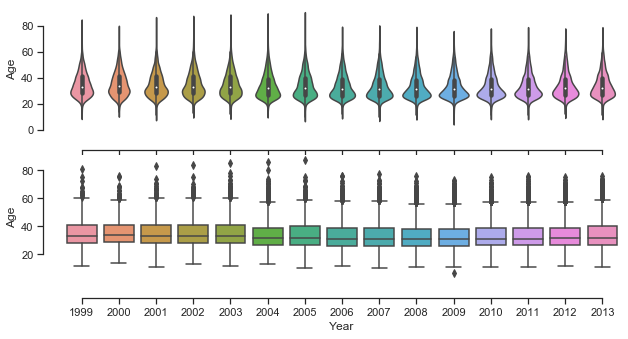

In [71]:
f, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="Year", y="Age", data=df1, ax=axes[1])
sns.violinplot(x="Year", y="Age", data=df1, ax=axes[0])
sns.despine(offset=20, trim=True)

Box plots of the age distributions both by year and in aggregate seem to visually validate the presensence of outliers that could possibly be skewing the data. As measures of mean are sensitive to the precense of outliers we must determine if the outliers need to be removed or if we need to use a method that does not really on mean when testing the null hypothesis that there is not significant difference in the distribution of ages over time. 

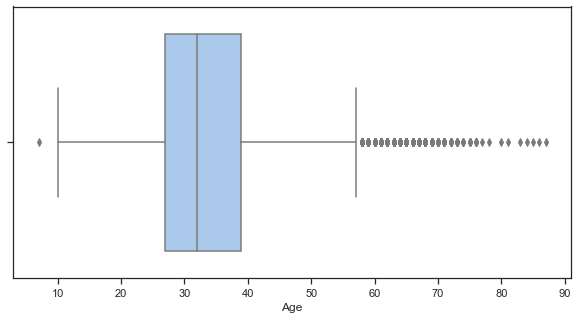

In [72]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["Age"])

The plot above provides us a distribution of the age groupings across all 13 years. On the high side of the mean, we can see there's a number of poarticipants over the age of 60 which heavily outweighs the number of outliers below the whisker at below 10 years old. 

Text(0, 0.5, 'Frequency')

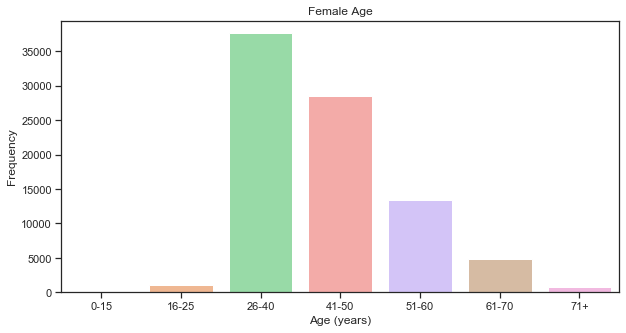

In [73]:
bins = [0, 10, 20, 30, 40, 50, 60, 70]
names = ['0-15', '16-25', '26-40', '41-50','51-60', '61-70','71+']

df1['AgeRange'] = pd.cut(df1['Age'], bins, labels=names)

plt.figure(figsize=(10,5))
#sns.set(style="ticks", palette="pastel")
sns.countplot('AgeRange', data=df1)

plt.title('Female Age'); plt.xlabel('Age (years)'); plt.ylabel('Frequency')

We created a series of bins within our age groupings so that we can more easily visualize our skewness in a histogram. Here, we can see the 26-40 grouping has the most representatives followed by the 41-50 group. As discussed previously, our theme of right skewness is apparent here as well. 

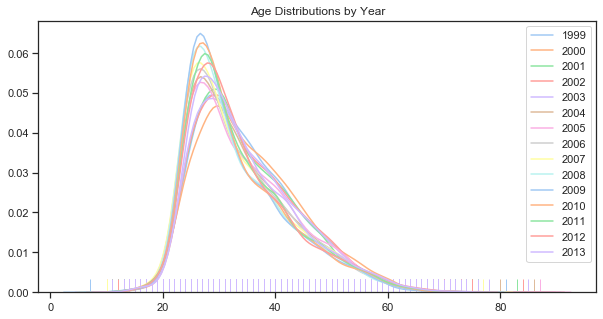

In [74]:
plt.figure(figsize=(10,5))
n = 1999
while n < 2014:
    YEAR = df1.loc[df1['Year'] == n]
    sns.distplot(YEAR[['Age']], hist=False, rug=True, label=n)
    n+=1
plt.title("Age Distributions by Year")
plt.legend()

Review of the distribution plots validate that "Age" among female runners is not normally distributed and variations of the mean of the distributions from year to year seems to be more pronouced in the distribution plots. While the distributions indicate that there may be a shift in mean age over time it is difficult to conclusively determine the direction of the shift.

Text(0.5, 1.0, 'Total Age Distribution')

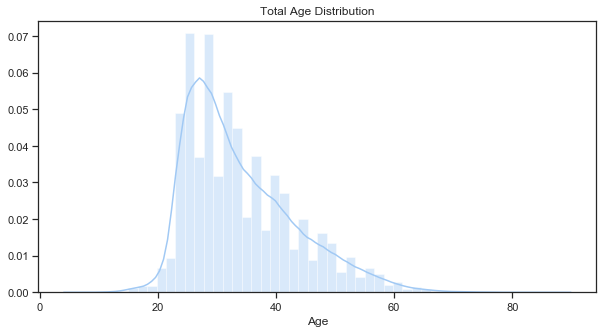

In [75]:
plt.figure(figsize=(10,5))
sns.distplot(df1['Age'])
plt.title("Total Age Distribution")

Review of the a kernel density plot seems to indicate that there is a change in the distrbution of "Age" over time. Additionally the plot seems to indicate a gradual increase in the density of runners under 30 years of age.

Text(0.5, 1.0, 'Age Density')

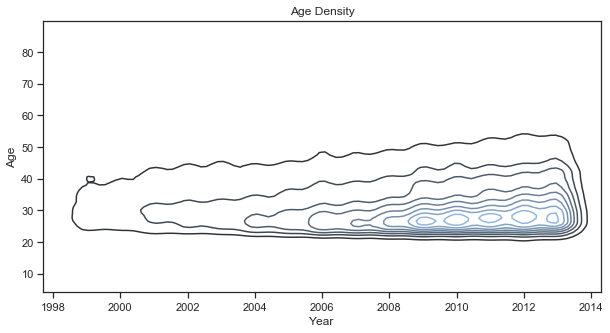

In [76]:
f, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(df1.Year, df1.Age, ax=ax)
plt.title("Age Density")

By comparing the mean age by year to the median age by year the effects of the the outliers on mean age are more noticeable. When looking at the range of the age axis it appears that the range between the lowest mean and the highest mean is less than 3 years and the range between the lowest median and the highest median is about 3 years. Whether this variation is significant or not will be the determined in the statistical testing section of our analysis.   

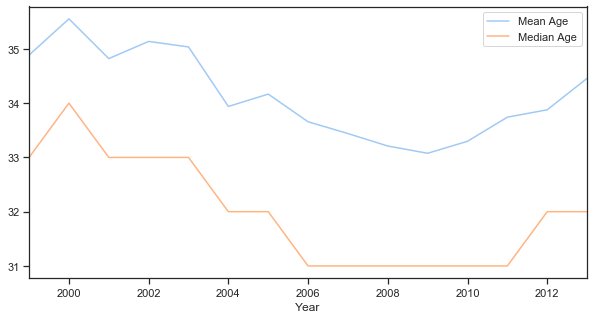

In [77]:
df1.groupby('Year')['Age'].mean().plot(kind='line', figsize=(10,5), label="Mean Age")
df1.groupby('Year')['Age'].median().plot(kind='line', figsize=(10,5),label="Median Age")
plt.legend()

The 20 ages with the lowest incidence rate were counted and plotted all together they accounted for only .12% of the the entire dataset. To analyze the impact of removing the outliers from the dataset a new data set was created that omitted all ages greater than 70 or less than 13. This was process was repeated with the lowest 25 and lowest 30 leading to new datasets that ommited .29% and .72% of the observations respectively. We chose this method because it detects anamolous data points on both sides of the mean and determines outliers by their frequency.

Text(0.5, 0, 'Age')

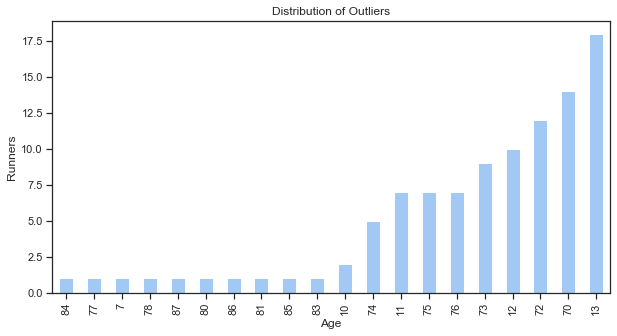

In [78]:
df1.Age.value_counts().nsmallest(20).plot(kind='bar', figsize=(10,5))
plt.title("Distribution of Outliers")
plt.ylabel("Runners")
plt.xlabel("Age")

In [79]:
df1.Age.value_counts().nsmallest(20).sum()/df1.Age.count()

0.0011721152618691176

In [80]:
df20 = df1[df1.Age < 70]
df20 = df20[df20.Age > 13]
df25 = df1[df1.Age < 67]
df25 = df25[df25.Age > 14]
df30 = df1[df1.Age < 63]
df30 = df30[df30.Age > 15]

,Year,Age
Year,1.000000,-0.033776
Age,-0.033776,1.000000


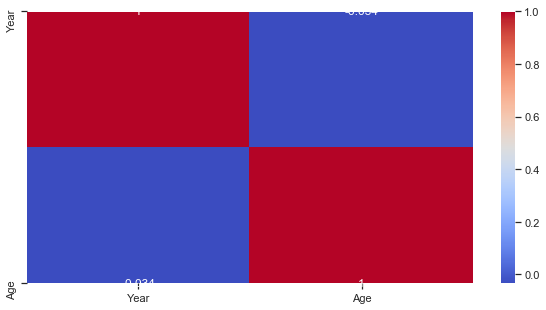

In [81]:
plt.figure(figsize=(10,5))
c= df1.corr()
sns.heatmap(c,cmap='coolwarm',annot=True)
c

Review of the correlation plot indicates a very weak negative correlation between year and age. Review of regression plot seems to indicate that overall the trend is for the average age to decrease over time. This trend is much more pronounced when only the mean age of each year is plotted.  

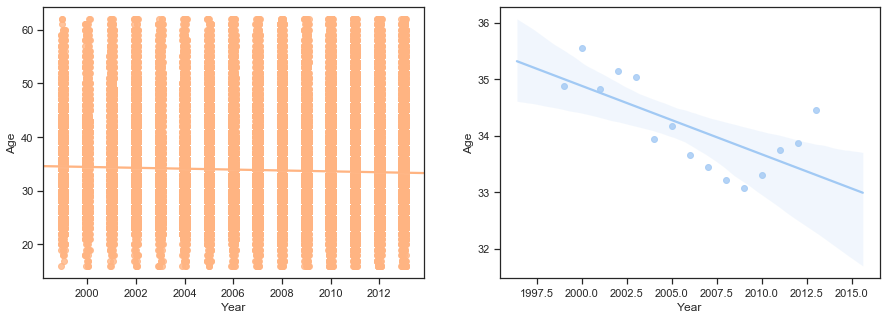

In [82]:
g = df1.groupby('Year')['Age'].mean().reset_index()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharey=False)
sns.regplot(x=g["Year"], y=g['Age'], ax=ax2)
sns.regplot(x=df30["Year"], y=df30['Age'],x_jitter=.1, ax=ax1)

However, when we look at the distribution of mean age for each year, there appears to be a change point in the data. To better capture this we plot a linear model plot with Locally Weighted Scatterplot Smoothing.This indicates that there may be a change point that occurs around 2009 where the general decrease in mean age starts an upward trend. Like all the other observations tests for statistical significance have to be conducted to validate the visual analysis. 

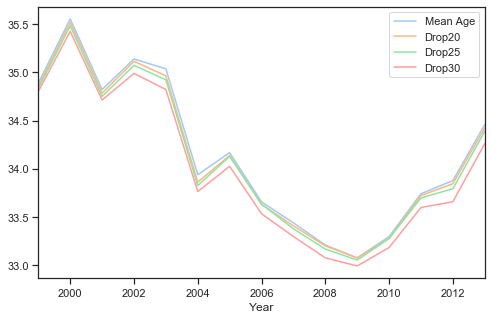

In [83]:
df1.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Mean Age")
df20.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Drop20")
df25.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Drop25")
df30.groupby('Year')['Age'].mean().plot(kind='line', figsize=(8,5), label="Drop30")
plt.legend()

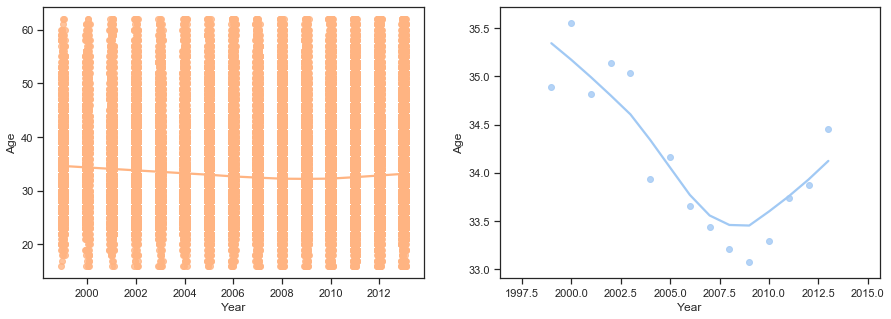

In [84]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharey=False)
sns.regplot(x=g["Year"], y=g['Age'], lowess = True, ax=ax2)
sns.regplot(x=df30["Year"], y=df30['Age'],x_jitter=.1, lowess = True, ax=ax1)


In [85]:
df1[["Pace","Time"]].describe()

,Pace,Time
count,86169,86169
unique,651,5199
top,00:09:52,1:36:34
freq,477,62


In [86]:
df1['RunTime'] = [int(a) * 60 + int(b) for a,b,c in df1['Time'].str.split(':')]

In [87]:
#create PaceTime variable
df1['PaceTime'] = [int(a) * 60 + int(b)* 60 + int(c) for a,b,c in df1['Pace'].str.split(':')]

### Summmary of EDA 

Overall, the average age of the runners in these races over the years hovers around the early to mid 30s. Each year, we found that our distribution of ages around the mean is generally right skewed, with most participants being in the age range of 26-50 with participants being as young as 8 and as old as 87. Each year, the distribution of ages changes relatively with the height of the bell curve changing every year. This would suggest that when more/less participants enter the race each year, these participants are most likely going to be very close to the mean. After reviewing the correlation between our remaining time, age and year variables, we saw that there was a very slight negative correlation between age and year, while a slightly more positive correlation between age and time. This kind of gives us evidence to form a hypothesis around our key project question that the age distribution is getting younger each year, despite the fact that repeat participants are going to be getting older with the passing year. Reviewing a line plot showing the age each year, we can see our hypothesis being supported as the average age is generally decreasing from 2000 to 2009 until we see an upswing where the average age is getting older. 

# Question of Interest
Has the age distribution of Female runners significantly changed over time? If so has the change occured over time or is there an evident break point?

## Hypothesis
    

*Null Hypotheses*: There is no change in the Age distributions of each Year.

*Alternative Hypotheses*: At least, one Year has an different Age distribution.

## ANOVA
As the fundametal question of interest is determining there us a difference in the age over time and each year essentially represents an independant group of runners, we decided to start with ANOVA which compare two means from independent groups using the F-distribution. ANOVA tests against the null hypothesis that there is no significant difference in the means of classes. 

#### Assumptions:

Residuals are normally distributed (Shapiro Wilks Test)

Homogeneity of variances (Bartlett Test)

Observations are sampled independently from each other

#### Concerns
In our case we will have 15 classes and the classes are unbalanced. While there is a slight concern that this will adveresly affect homogeneity of variances, we hope that the effects fo the unbalanced classes will be mitigated by the large samples per group and the fact that we are testing against only one variable. While we assume that the age distribution of one year should be independant of another we found that while there were a total of 138,265 registered female runners there were only 82,157 indicating that up to 40.1% of the runners participated in multiple years. As runners naturally naturally age from year to year this makes a runners age in one year dependant on their age in a previous year. 

In order to conduct ANOVA we convert the values in the df20 dataframe from integer to classes by casting them as string objects. We also create a data set of the summary statistics for each year.

In [88]:
#create dateframe of summary statistics by year
dfAgeStats = df1.groupby('Year')['Age'].describe().reset_index()
#create dataframe where Year is a class variable
df20["Year"] = df20["Year"].astype(str) 
df1.groupby('Year')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
1999,2354.0,34.886576,8.925263,12.0,28.0,33.0,41.0,81.0
2000,2166.0,35.553555,9.319658,14.0,29.0,34.0,41.0,76.0
2001,2971.0,34.821272,9.186583,11.0,28.0,33.0,41.0,83.0
2002,3330.0,35.137838,9.231994,13.0,28.0,33.0,41.0,84.0
2003,3525.0,35.036028,9.370971,12.0,28.0,33.0,41.0,85.0
2004,3885.0,33.939254,9.289703,13.0,27.0,32.0,39.0,86.0
2005,4323.0,34.166551,9.385567,10.0,27.0,32.0,40.0,87.0
2006,5435.0,33.657038,9.255073,12.0,26.0,31.0,39.0,76.0
2007,5530.0,33.439964,9.255429,10.0,26.0,31.0,39.0,77.0


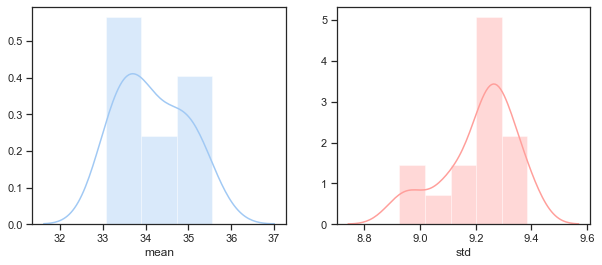

In [89]:
#distribution of standard deviations
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
#sns.regplot(x="Year", y="std", data=dfAgeStats, ax=ax2)
sns.distplot(dfAgeStats['mean'], ax=ax1)
sns.distplot(dfAgeStats['std'], ax=ax2, color='r')

We take a quick look at the distribution of the mean and standard deviations of the grouped ages and run our ANOVA and it returns an F score of 31.13 and a p-value significantly lower than our significance threshhold of .05 indicating that the mean distribution of atleast one group is significantly different than that of the other groups.    

In [90]:
#one-way anova model age grouped across year
model = ols('Age ~ Year', data=df20).fit()
table = sm.stats.anova_lm(model, typ=2)
print("          One-way ANOVA of Age distibutions for Years 1999-2013","\n\n", table)

          One-way ANOVA of Age distibutions for Years 1999-2013 

                 sum_sq       df          F        PR(>F)
Year      3.624647e+04     14.0  31.128203  6.005014e-84
Residual  7.155726e+06  86034.0        NaN           NaN


#### Normal Distribution of Residuals 

In [91]:
#Shapiro-Wilks tests for normality of model residuals
w, pvalue = stats.shapiro(model.resid)
print("Test Statistic against Null Hypothesis of Normal Distribution: ", round(w,4),'\n' "p=value: ", round(pvalue,4))

Test Statistic against Null Hypothesis of Normal Distribution:  0.9358 
p=value:  0.0


C:\Users\gouki\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


We run a Shapiro-Wilks test for normality but due to the high sample size the p-value is not conslusive. So we plot the residuals on a distribution plot and a QQ plot. The plots indicate that the residuals are not evenly distributed.   

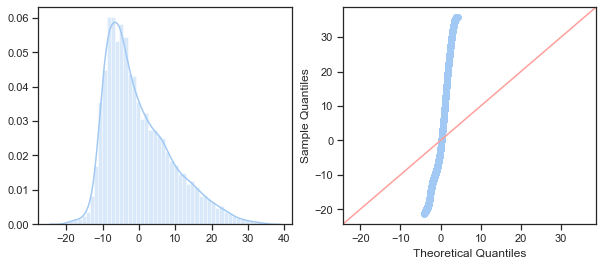

In [92]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
#plt.figure(figsize=(10,5))
sns.distplot(model.resid, ax=ax1)
sm.qqplot(model.resid, line ='45',ax=ax2) 
py.show() 

#### Homogeneity of Variances

In [93]:
#bartlett test for homogeneity of variances
w, pvalue = stats.bartlett( df20.loc[df20['Year'] == "1999", 'Age'], df20.loc[df20['Year'] == "2000", 'Age'], df20.loc[df20['Year'] == "2001", 'Age'], 
                            df20.loc[df20['Year'] == "2003", 'Age'], df20.loc[df20['Year'] == "2004", 'Age'], df20.loc[df20['Year'] == "2005", 'Age'],
                            df20.loc[df20['Year'] == "2006", 'Age'], df20.loc[df20['Year'] == "2007", 'Age'], df20.loc[df20['Year'] == "2008", 'Age'],
                            df20.loc[df20['Year'] == "2009", 'Age'], df20.loc[df20['Year'] == "2010", 'Age'], df20.loc[df20['Year'] == "2011", 'Age'],
                            df20.loc[df20['Year'] == "2012", 'Age'], df20.loc[df20['Year'] == "2013", 'Age'])
print("Test Statistic against Null Hypothesis of equal variance: ", round(w,4),'\n' "p=value: ", round(pvalue,4))

Test Statistic against Null Hypothesis of equal variance:  27.1705 
p=value:  0.0118


We go on to test the homogeneity of variances using a bartlett test and the resulting p-value of .0118 indicates that the we cannot assume homogeneity of variances. Though our assumptions were not porperly satisfied we still go on and conduct a multiple pairwise comparison of the groups as the EDA still validates the results of the ANOVA. 

#### Tukey HD

In [94]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=df20['Age'], groups=df20['Year'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  1999   2000   0.6635 0.4855 -0.2581  1.5851  False
  1999   2001  -0.0697    0.9  -0.924  0.7847  False
  1999   2002   0.2609    0.9 -0.5728  1.0945  False
  1999   2003   0.1096    0.9 -0.7146  0.9338  False
  1999   2004  -0.9919 0.0029 -1.8007 -0.1832   True
  1999   2005  -0.7155 0.1305 -1.5085  0.0775  False
  1999   2006  -1.2216  0.001 -1.9855 -0.4578   True
  1999   2007  -1.4444  0.001 -2.2062 -0.6825   True
  1999   2008  -1.6518  0.001 -2.3982 -0.9055   True
  1999   2009  -1.7763  0.001 -2.4991 -1.0535   True
  1999   2010   -1.575  0.001 -2.2929  -0.857   True
  1999   2011  -1.1301  0.001 -1.8466 -0.4136   True
  1999   2012   -1.008  0.001 -1.7192 -0.2969   True
  1999   2013  -0.4298 0.7307  -1.137  0.2773  False
  2000   2001  -0.7332  0.224 -1.6077  0.1413  False
  2000   2002  -0.4027    0.9 -1.2569  0.4516 

<u> Change Point / Mean Diff </u><br />
2004: -0.9919  
2008: -0.6599  
2011:  0.5217   

The pairwise comaparison identifies 3 possible change points. Though the points seem to correlate with our visual analysis, the Tukey HD test requires that the same assumpitions be met as ANOVA, so we merely note these points but move on to a non-parametric comparison of distibutions and do a pairwise comparison using the Kolmogorov-Smirnov test of equal distribution.

(1998, 2014)

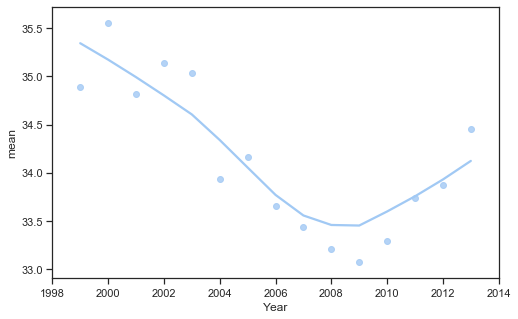

In [95]:
plt.figure(figsize=(8,5))
sns.regplot(x="Year", y="mean", data=dfAgeStats, lowess=True)
plt.xlim(1998, 2014)

In [96]:
#Kolmogorov-Smirnov test of equal distribution
from scipy.stats import ks_2samp
y1=1999
y2=2000

while y1 < 2013:
    x = df30.loc[df30['Year'] == y1, 'Age']; y = df30.loc[df30['Year'] == y2, 'Age']
    print(y1,"/",y2, " p-value", round(ks_2samp(x, y)[1],8))
    y1+=1
    y2+=1

1999 / 2000  p-value 0.10283367
2000 / 2001  p-value 0.99561583
2001 / 2002  p-value 1.0
2002 / 2003  p-value 1.0
2003 / 2004  p-value 1.0
2004 / 2005  p-value 1.0
2005 / 2006  p-value 1.0
2006 / 2007  p-value 1.0
2007 / 2008  p-value 1.0
2008 / 2009  p-value 1.0
2009 / 2010  p-value 1.0
2010 / 2011  p-value 1.0
2011 / 2012  p-value 1.0
2012 / 2013  p-value 5.2e-07


Using the Kolmogorov-Smirnov test we identify a change point as a year pairing that is significantly different, but where neither the previous the previous pairing nor subsequent pairing are significantly different and where three consecutive similar pairings are a considered a trend. The results of the tests suggest that at a significance level of p < .01; 2000:2001, 2003:2004, and 2010:2011 indicate that a change point may have occured.  

# Linear Regression
Next we will explore linear regression techniques to see if we can forecast future average ages as well as see if we can predict the ages of the runners based on the year.

In [113]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [114]:
#separating input data into two parts X (features) and Y (target)
features = ['Year', 'RunTime', 'PaceTime']

X = df1[features].copy()

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation

Y= df1[['Age']].copy()
Y.shape

(86169, 1)

#### Cross Validation

In [115]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [116]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [117]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

#### Making Custom Estimators

In [118]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100)

#### Baseline LInear Regression Grid Search

In [119]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters3 = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearchbase = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters3
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearchbase.fit(X, Y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=CappedLinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [120]:
#Print the parameterization of the best estimator
regGridSearchbase.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)

In [121]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimatorbase = regGridSearchbase.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimatorbase, X, Y, cv)

C:\Users\gouki\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:634: FutureWarning: `item` has been deprecated and will be removed in a future version
  score = score.item()
C:\Users\gouki\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:634: FutureWarning: `item` has been deprecated and will be removed in a future version
  score = score.item()
C:\Users\gouki\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:634: FutureWarning: `item` has been deprecated and will be removed in a future version
  score = score.item()
C:\Users\gouki\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:634: FutureWarning: `item` has been deprecated and will be removed in a future version
  score = score.item()
C:\Users\gouki\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:634: FutureWarning: `item` has been deprecated and will be removed in a future version
  score = score.item()
C:\Users\gouki\Anaconda3\lib\site-packag

The average MAE for all cv folds is: 			 7.3529
The average MAE percentage (MAPE) for all cv folds is: 	 22.332
The average RMSE for all cv folds is: 			 9.1564
*********************************************************
Cross Validation Fold Mean Error Scores


C:\Users\gouki\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:634: FutureWarning: `item` has been deprecated and will be removed in a future version
  score = score.item()
C:\Users\gouki\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:634: FutureWarning: `item` has been deprecated and will be removed in a future version
  score = score.item()


,MAE,MAPE,RMSE
0,7.362397,22.203248,9.202555
1,7.346731,22.245239,9.178634
2,7.417983,22.592230,9.213945
3,7.367599,22.418641,9.145784
4,7.361852,22.244816,9.170254
5,7.372857,22.381290,9.192536
6,7.296773,22.271703,9.061802
7,7.335179,22.303049,9.122885
8,7.302884,22.333188,9.088240
9,7.364664,22.329016,9.187160



Seems like we are off by an average of over 9 years using a baseline linear regression. Next lets try a ridge regression to see if we perform better.

#### Ridge Regression

This model will use Lasso Regressions (L2 Norm) for regression of continuious variables. Documentation below:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [122]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

regrid = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpharid = [0.001, 0.1, 1, 5, 10, 20]
solverrid = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parametersrid = {'alpha': alpharid, 'solver': solverrid}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearchrid = GridSearchCV(estimator=regrid
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parametersrid
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearchrid.fit(X, Y)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   16.8s


ValueError: ndarray is not C-contiguous

In [123]:
#Display the best estimator parameters
regGridSearchrid.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [124]:
#Create a regression estimator with best parameters for cross validation
regEstimatorrid = regGridSearchrid.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimatorrid, X, Y, cv)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

After performing a ridge regression, we didn't perform any better than our baseline linear regression. This is likely due to our age group and race times being highly varied. So the relationship between age and race time is going to be muddied by the variances.

Next let's do a simple linear regression to predict the average age of 2013's data using the data from 1999 - 2012.

Now let's set up our dataframe so that we are grouping the ages by year.

In [125]:
dfage = df1.groupby('Year')['Age'].mean().reset_index()

In [126]:
dfage

,Year,Age
0,1999,34.886576
1,2000,35.553555
2,2001,34.821272
3,2002,35.137838
4,2003,35.036028
5,2004,33.939254
6,2005,34.166551
7,2006,33.657038
8,2007,33.439964
9,2008,33.210008


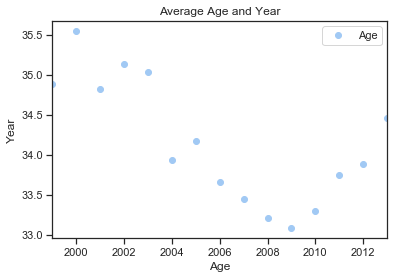

In [127]:
dfage.plot(x='Year', y='Age', style='o')  
plt.title('Average Age and Year')  
plt.xlabel('Age')  
plt.ylabel('Year')  
plt.show()

In [128]:
list(dfage.columns.values)

['Year', 'Age']

In [129]:
x = dfage['Year'].values.reshape(-1,1)
y = dfage['Age'].values.reshape(-1,1)

We will set our training and testing split so that it will only test our final row, the 2013 data.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.06, shuffle=False)

In [131]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [132]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[352.95251056]
[[-0.15897334]]


In [133]:
y_pred = regressor.predict(X_test)

In [134]:
dfreg = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
dfreg

,Actual,Predicted
0,34.457231,32.939182


In [135]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.518049114227935
Mean Squared Error: 2.304473113208218
Root Mean Squared Error: 1.518049114227935


#### Simple Linear Regression

In [ ]:
import statsmodels.formula.api as smf
plt.rcParams['figure.figsize'] = (10, 5)
x = df1["Year"]
y = df1["Age"]

# linear regression
f1 = smf.ols(formula = 'Age ~ Year', data = df1).fit()
df1['f1_pred'] = f1.predict()
print(f1.summary())

fig = plt.figure()
fig.patch.set_alpha = 0.5

ax = fig.add_subplot(111)
plt.scatter(x, y, s = 5, marker = '.')
ax.plot(df1.Year, df1.f1_pred, linestyle = '-', linewidth = 1, marker = '', label = r'lin-reg', color='r')
plt.show()

#### Piecewise Regression

In [ ]:
from scipy import optimize
x=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = dfAgeStats["mean"].values

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(1, 16, 100)
#xd = np.linspace(1999, 2014, 100)

plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p)) 


In [ ]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

In [ ]:
df1.groupby('Year')['Time'].mean().plot(kind='line', figsize=(8,5), label="Mean Mean")
t = df1.groupby('Year')['Time'].mean().reset_index()
sns.regplot(x="Year", y="Time", data=t, lowess=True)

# Conclusion